In [83]:
from __future__ import print_function

from pyspark.sql import SparkSession

from pyspark.sql import Row

from pyspark.sql.types import *

import matplotlib.pyplot as plt

import pandas as pd  

import numpy as np

import pylab as P

%matplotlib inline

plt.rcdefaults()

incidentDAT = sc.textFile("/whitstable/data/incident.txt")
incidentDAT.count()


260364

In [84]:
incidentRDD = incidentDAT.map(lambda x: x.split("\t")).map(lambda x: Row(x[0], x[1], x[2], x[3], x[4], x[5], x[6] ))
incidentDFrame = incidentRDD.toDF(["gross_ton","vlength","vdepth","vessel_class","vessel_age","route_type","Accident"])
incidentDFrame.printSchema()
incidentDFrame.show(5)
incidentDFrame.createOrReplaceTempView("vessel")

root
 |-- gross_ton: string (nullable = true)
 |-- vlength: string (nullable = true)
 |-- vdepth: string (nullable = true)
 |-- vessel_class: string (nullable = true)
 |-- vessel_age: string (nullable = true)
 |-- route_type: string (nullable = true)
 |-- Accident: string (nullable = true)

+---------+-------+------+------------+----------+--------------------+--------+
|gross_ton|vlength|vdepth|vessel_class|vessel_age|          route_type|Accident|
+---------+-------+------+------------+----------+--------------------+--------+
|    159.0|   89.3|  12.0|Recreational|      70.0|         UNSPECIFIED|     Yes|
|      0.0|  250.0|  10.5|       Barge|      65.0|         UNSPECIFIED|     Yes|
|   9876.0|  459.8|  36.2|       Barge|      22.0|              Oceans|     Yes|
|   1830.0|  284.0|  11.2|       Barge|      53.0|"Lakes, Bays, and...|     Yes|
|   1983.0|  209.5|  12.5|    Offshore|      35.0|         UNSPECIFIED|     Yes|
+---------+-------+------+------------+----------+----------

# Distribution of vessel class

In [85]:
VesselClassDF = spark.sql("SELECT vessel_class, count(vessel_class) as vessel_classcount FROM vessel GROUP BY vessel_class ORDER BY vessel_classcount")
VesselClassDF.show()

+--------------------+-----------------+
|        vessel_class|vessel_classcount|
+--------------------+-----------------+
|         School Ship|              186|
|             Warship|              344|
|Refrigerated Carg...|              568|
|       Research Ship|              978|
|    Ro-Ro Cargo Ship|             1074|
|            Offshore|             2186|
|         UNSPECIFIED|             6255|
|        Bulk Carrier|             7627|
|Miscellaneous Vessel|             7739|
|           Tank Ship|             8348|
|               Barge|             8848|
|       Towing Vessel|             9678|
|General Dry Cargo...|            15316|
|      Passenger Ship|            20887|
|      Fishing Vessel|            44944|
|        Recreational|           125386|
+--------------------+-----------------+



In [86]:
vessel_classTuple = VesselClassDF.rdd.map(lambda p: (p.vessel_class,p.vessel_classcount)).collect()
vessel_classList, vessel_classcountList = zip(*vessel_classTuple)

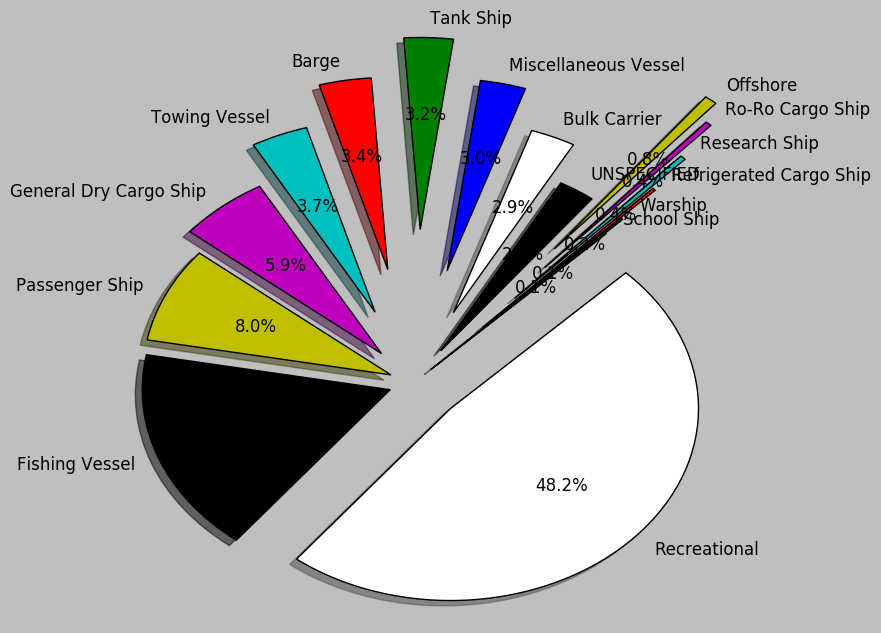

In [87]:
explode = (0.1,0.2,0.4,0.6,0.8,0.9,0.2,0.4,0.6,0.8,0.6,0.4,0.2,0.1,0.1,0.2)  
plt.pie(vessel_classcountList, explode=explode, labels=vessel_classList, autopct='%1.1f%%', shadow=True, startangle=45)
plt.title('\n')
plt.show(block=False)

#### Distribution of vessel class involved in accidents

In [88]:
vesselAccident = spark.sql("SELECT vessel_class, Accident FROM vessel")
vesselAccident.show()

+--------------------+--------+
|        vessel_class|Accident|
+--------------------+--------+
|        Recreational|     Yes|
|               Barge|     Yes|
|               Barge|     Yes|
|               Barge|     Yes|
|            Offshore|     Yes|
|      Fishing Vessel|     Yes|
|       Towing Vessel|     Yes|
|General Dry Cargo...|     Yes|
|       Towing Vessel|     Yes|
|       Towing Vessel|     Yes|
|      Fishing Vessel|     Yes|
|      Passenger Ship|     Yes|
|       Towing Vessel|     Yes|
|        Recreational|     Yes|
|        Bulk Carrier|     Yes|
|            Offshore|     Yes|
|General Dry Cargo...|     Yes|
|General Dry Cargo...|     Yes|
|        Bulk Carrier|     Yes|
|      Passenger Ship|     Yes|
+--------------------+--------+
only showing top 20 rows



In [89]:
vesselCrossTab = vesselAccident.stat.crosstab("vessel_class", "Accident")
vesselCrossTab.show()

+---------------------+------+---+
|vessel_class_Accident|    No|Yes|
+---------------------+------+---+
|       Fishing Vessel| 44119|825|
| Refrigerated Carg...|   551| 17|
| Miscellaneous Vessel|  7615|124|
| General Dry Cargo...| 15118|198|
|                Barge|  8660|188|
|             Offshore|  1989|197|
|        Research Ship|   959| 19|
|        Towing Vessel|  8912|766|
|       Passenger Ship| 19972|915|
|            Tank Ship|  8156|192|
|              Warship|   336|  8|
|         Recreational|125189|197|
|     Ro-Ro Cargo Ship|  1051| 23|
|         Bulk Carrier|  7430|197|
|          UNSPECIFIED|  6251|  4|
|          School Ship|   181|  5|
+---------------------+------+---+



In [90]:
vesselCrossTab.describe('No', 'Yes').show()

+-------+------------------+------------------+
|summary|                No|               Yes|
+-------+------------------+------------------+
|  count|                16|                16|
|   mean|        16030.5625|          242.1875|
| stddev|31106.463542633173|306.66251129431083|
|    min|               181|                 4|
|    max|            125189|               915|
+-------+------------------+------------------+



In [91]:
vesselCrossTab.stat.cov('No', 'Yes')

2207367.154166667

In [73]:
vesselCrossTab.stat.corr('No', 'Yes')

0.23139994350989657

In [92]:
vsaTuple = vesselCrossTab.rdd.map(lambda p: (p.vessel_class_Accident,p.No, p.Yes)).collect()
vsaList, nList, yList = zip(*vsaTuple)

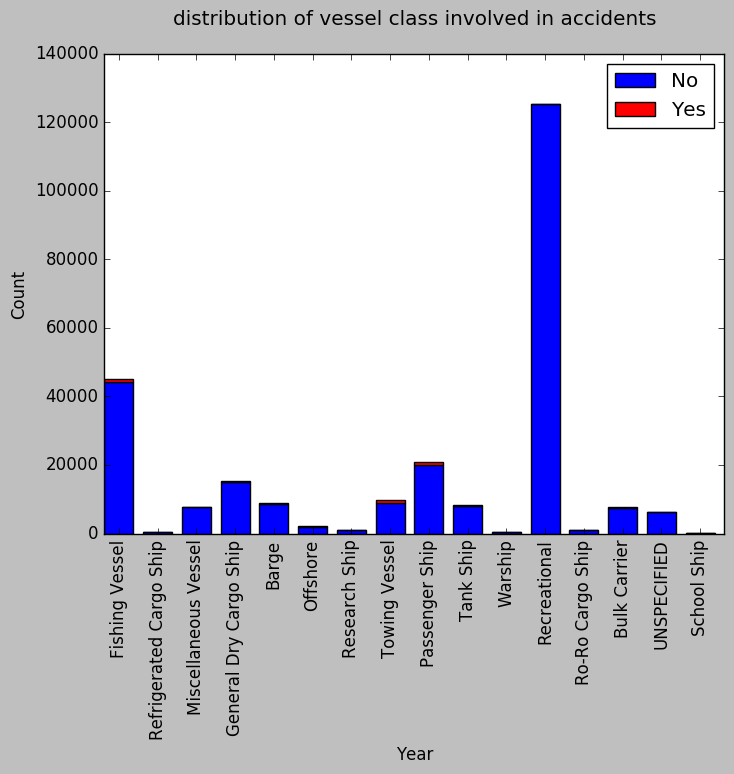

In [109]:
N = len(vsaList)
ind = np.arange(N)    
width = 0.75          
p1 = plt.bar(ind, nList, width, color='b')
p2 = plt.bar(ind, yList, width, color='r', bottom=nList)
plt.ylabel('Count')
plt.title('distribution of vessel class involved in accidents\n')
plt.xticks(ind + width/2., vsaList, rotation=90)
plt.legend((p1[0], p2[0]), ('No', 'Yes'))
plt.gcf().subplots_adjust(bottom=0.10)
plt.show(block=False)